In [2]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


In [3]:
stats = get_all_stats()

  0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
def logistic_regression_I(network_index: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(
      f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

auc_I = {
  network_index: logistic_regression_I(network_index) 
  for network_index in network_indices}

In [5]:
def logistic_regression_I_II(network_index: int, hypergraph: bool):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(
        f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy'))
    
  if hypergraph:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
        for aggregation_strategy in aggregation_strategies:
          X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'
            ))
  else:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
          X[(time_strategy, nodepair_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_I_II = {
  network_index: (
    logistic_regression_I_II(
      network_index, hypergraph=network_index in hypergraphs
    )
  )
  for network_index in network_indices
}

In [6]:
def logistic_regression_III(network_index: int, hypergraph: bool):
  X = dict()
  
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      if hypergraph:
        for aggregation_strategy in aggregation_strategies:
          if aggregation_strategy not in ['m2', 'm3']:
            X[(heuristic, time_strategy, aggregation_strategy)] = np.load(
                f'data/{network_index:02}/features/time_edge/'
                f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
      else:
        X[(heuristic, time_strategy)] = np.load(
          f'data/{network_index:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy')
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_III = {
  network_index: logistic_regression_III(
    network_index, hypergraph=network_index in hypergraphs)
  for network_index in network_indices}

In [9]:
stats.columns

Index(['edges', 'density (nx.MultiGraph)', 'fraction edges in GC', 'nodes',
       'avg events per pair', 'density', 'degree assortativity',
       'average clustering coefficient', 'fraction nodes in GC',
       'avg events per pair in GC'],
      dtype='object')

In [12]:
df = pd.DataFrame({
  'degree assortativity': stats['degree assortativity'],
  'I': pd.Series(auc_I),
  'I+II': pd.Series(auc_I_II),
  'III': pd.Series(auc_III)
})
df.reset_index(inplace=True)

In [14]:
df = df.melt(
  id_vars=['index', 'degree assortativity'], 
  var_name='experiment', 
  value_name='auc')

In [15]:
df

,index,degree assortativity,experiment,auc
0,1,0.114186,I,0.695024
1,2,0.059906,I,0.810433
2,3,-0.166689,I,0.847715
3,4,0.221522,I,0.766331
4,5,0.177355,I,0.682705
...,...,...,...,...
73,24,-0.078326,III,0.886301
74,25,-0.064984,III,0.901347
75,28,-0.087156,III,0.899745
76,29,-0.137222,III,0.921672


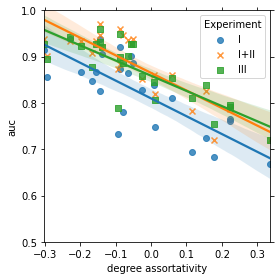

In [17]:
markers = ['o', 'x', 's']
with plt.rc_context(rc):
  for (experiment, df_experiment), marker in zip(df.groupby('experiment'), markers):
    sns.regplot(
      data=df_experiment, x='degree assortativity', y='auc', label=experiment,
      marker=marker)
  plt.legend(title='Experiment')
  plt.ylim(.5, 1)
  plt.tight_layout()
  plt.savefig('figures/degree-assortativity.pdf')